In [2]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dataset_path = os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 42
EXCLUDED_CLASSES = ['clothes', 'shoes']

In [3]:
CLASS_MAPPING = {
    'battery': 'battery',
    'biological': 'trash',
    'brown-glass': 'glass',
    'cardboard': 'cardboard',
    'green-glass': 'glass',
    'metal': 'metal',
    'paper': 'paper',
    'plastic': 'plastic',
    'trash': 'trash',
    'white-glass': 'glass'
}

In [4]:
all_classes = sorted(os.listdir(dataset_path))
classes = [c for c in all_classes if c not in EXCLUDED_CLASSES]
print("Original classes (excluding clothes and shoes):", classes)

Original classes (excluding clothes and shoes): ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass']


In [5]:
metadata = []
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            metadata.append({"image_path": img_path, "class": class_name, "mapped_class": CLASS_MAPPING[class_name]})

df_metadata = pd.DataFrame(metadata)
new_classes = sorted(df_metadata['mapped_class'].unique())
print("\nClasses after mapping (7 classes):", new_classes)


Classes after mapping (7 classes): ['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [6]:
# Count per original class (10 classes)
original_counts = df_metadata['class'].value_counts().sort_index()
print("\n• ORIGINAL Classes (10 classes):")
print(original_counts)

# Counting by mapped class (7 classes)
mapped_counts = df_metadata['mapped_class'].value_counts().sort_index()
print("\n• MAPPED Classes (7 classes):")
print(mapped_counts)

total_images = len(df_metadata)
print(f"\n• Total number of images: {total_images}")


• ORIGINAL Classes (10 classes):
class
battery         945
biological      985
brown-glass     607
cardboard       891
green-glass     629
metal           769
paper          1050
plastic         865
trash           697
white-glass     775
Name: count, dtype: int64

• MAPPED Classes (7 classes):
mapped_class
battery       945
cardboard     891
glass        2011
metal         769
paper        1050
plastic       865
trash        1682
Name: count, dtype: int64

• Total number of images: 8213


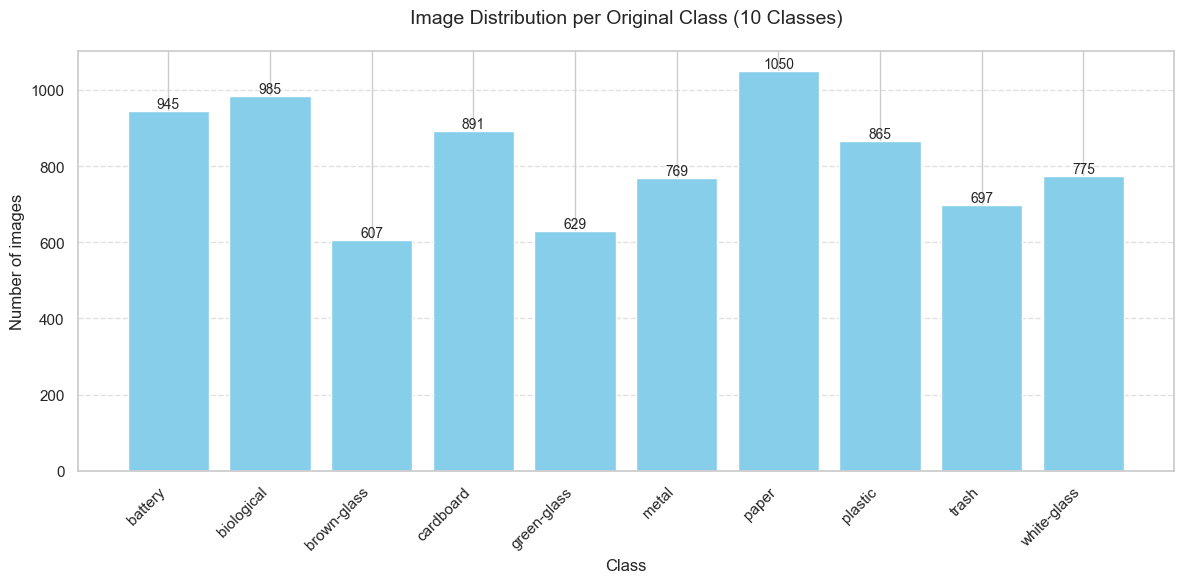

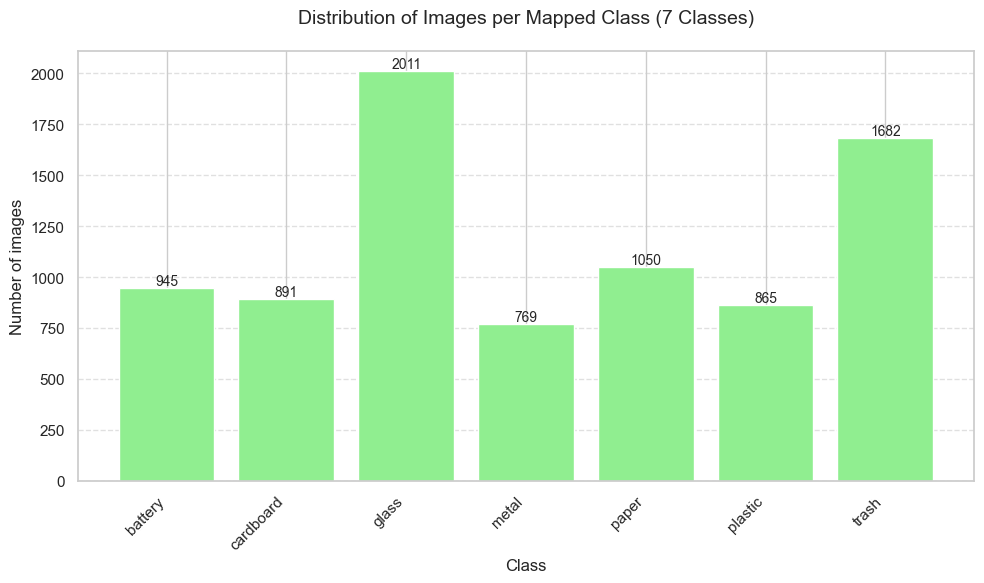


• TOTAL NUMBER OF IMAGES IN THE DATASET: 8213


In [7]:
sns.set_theme(style="whitegrid", palette="pastel")

plt.figure(figsize=(12, 6))
original_counts = df_metadata['class'].value_counts().sort_index()
bars_original = plt.bar(original_counts.index, original_counts.values, color='skyblue')

plt.title('Image Distribution per Original Class (10 Classes)', fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add values above the bars
for bar in bars_original:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
mapped_counts = df_metadata['mapped_class'].value_counts().sort_index()
bars_mapped = plt.bar(mapped_counts.index, mapped_counts.values, color='lightgreen')

plt.title('Distribution of Images per Mapped Class (7 Classes)', fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars_mapped:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

total_images = len(df_metadata)
print(f"\n• TOTAL NUMBER OF IMAGES IN THE DATASET: {total_images}")


• MAPPED Classes (4 classes):
mapped_class_4
glass      2011
other      3396
paper      1941
plastic     865
Name: count, dtype: int64


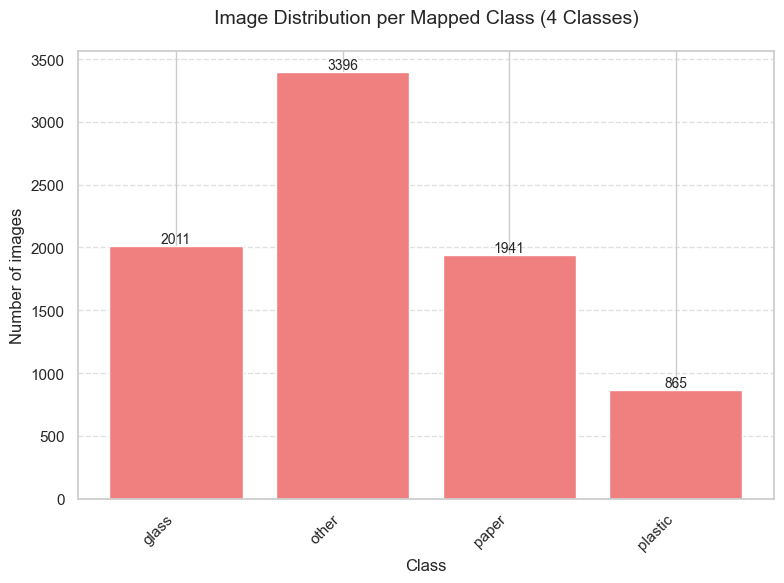

In [8]:
# Define the mapping for 4 classes
class_mapping_4_classes = {
    'brown-glass': 'glass',
    'green-glass': 'glass',
    'white-glass': 'glass',
    'cardboard': 'paper',
    'paper': 'paper',
    'plastic': 'plastic',
    'metal': 'other',
    'battery': 'other',
    'biological': 'other',
    'trash': 'other'
}

mapped_4_classes = sorted(list(set(class_mapping_4_classes.values())))

# Map the original classes to the new 4 classes in the DataFrame
df_metadata['mapped_class_4'] = df_metadata['class'].map(class_mapping_4_classes)

# Counting by mapped class (4 classes)
mapped_4_counts = df_metadata['mapped_class_4'].value_counts().sort_index()
print("\n• MAPPED Classes (4 classes):")
print(mapped_4_counts)

plt.figure(figsize=(8, 6))
bars_mapped_4 = plt.bar(mapped_4_counts.index, mapped_4_counts.values, color='lightcoral')

plt.title('Image Distribution per Mapped Class (4 Classes)', fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars_mapped_4:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
# Split data
train_df, temp_df = train_test_split(
    df_metadata, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=df_metadata['mapped_class']
)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=SEED, 
    stratify=temp_df['mapped_class']
)

In [ ]:
# Data generators with the new classes
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=dataset_path,
    x_col="image_path",
    y_col="mapped_class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=new_classes,
    seed=SEED,
    shuffle=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rescale=1./255
)
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=dataset_path,
    x_col="image_path",
    y_col="mapped_class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=new_classes,
    seed=SEED,
    shuffle=False
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_path,
    x_col="image_path",
    y_col="mapped_class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=new_classes,
    seed=SEED,
    shuffle=False
)

Found 6570 validated image filenames belonging to 7 classes.
Found 821 validated image filenames belonging to 7 classes.
Found 822 validated image filenames belonging to 7 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(new_classes), activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
checkpoint_filepath = 'best_model_7_classes.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)
callbacks_list = [early_stopping, lr_scheduler, model_checkpoint]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50
205/205 [==============================] - ETA: 0s - loss: 1.8839 - accuracy: 0.3084
Epoch 1: val_loss improved from inf to 1.83019, saving model to best_model_7_classes.h5
205/205 [==============================] - 292s 1s/step - loss: 1.8839 - accuracy: 0.3084 - val_loss: 1.8302 - val_accuracy: 0.2425 - lr: 1.0000e-04
Epoch 2/50
205/205 [==============================] - ETA: 0s - loss: 1.6924 - accuracy: 0.3810
Epoch 2: val_loss improved from 1.83019 to 1.73489, saving model to best_model_7_classes.h5
205/205 [==============================] - 303s 1s/step - loss: 1.6924 - accuracy: 0.3810 - val_loss: 1.7349 - val_accuracy: 0.3375 - lr: 1.0000e-04
Epoch 3/50
205/205 [==============================] - ETA: 0s - loss: 1.6368 - accuracy: 0.4058
Epoch 3: val_loss did not improve from 1.73489
205/205 [==============================] - 337s 2s/step - loss: 1.6368 - accuracy: 0.4058 - val_loss: 1.9938 - val_accuracy: 0.3350 - lr: 1.0000e-04
Epoch 4/50
205/205 [==================

In [ ]:
best_model = load_model('best_model_7_classes.h5')

loss, accuracy = best_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_probs = best_model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for i in range(test_generator.samples // BATCH_SIZE):
    _, labels = test_generator[i]
    y_true.extend(np.argmax(labels, axis=1))
y_true = np.array(y_true)

report = classification_report(y_true, y_pred, target_names=new_classes, zero_division=0)
print("Classification Report (Test Set):\n", report)

25/25 [==============================] - 29s 1s/step - loss: 1.1641 - accuracy: 0.6012
Test Loss: 1.1641
Test Accuracy: 0.6012
25/25 [==============================] - 30s 1s/step
Classification Report (Test Set):
               precision    recall  f1-score   support

     battery       0.74      0.78      0.76        94
   cardboard       0.73      0.53      0.62        88
       glass       0.58      0.62      0.60       196
       metal       0.57      0.37      0.44        71
       paper       0.70      0.64      0.67       100
     plastic       0.39      0.40      0.39        83
       trash       0.57      0.70      0.63       168

    accuracy                           0.60       800
   macro avg       0.61      0.58      0.59       800
weighted avg       0.61      0.60      0.60       800



In [12]:
loss_val, accuracy_val = best_model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE, verbose=0)
print(f"Validation Loss: {loss_val:.4f}")
print(f"Validation Accuracy: {accuracy_val:.4f}")

y_pred_val_probs = best_model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
y_pred_val = np.argmax(y_pred_val_probs, axis=1)

y_true_val = []
for i in range(validation_generator.samples // BATCH_SIZE):
    _, labels = validation_generator[i]
    y_true_val.extend(np.argmax(labels, axis=1))
y_true_val = np.array(y_true_val)

report_val = classification_report(y_true_val, y_pred_val, target_names=new_classes, zero_division=0)
print("Classification Report (Validation Set):\n", report_val)

Validation Loss: 1.2783
Validation Accuracy: 0.5713
25/25 [==============================] - 29s 1s/step
Classification Report (Validation Set):
               precision    recall  f1-score   support

     battery       0.67      0.70      0.68        91
   cardboard       0.57      0.57      0.57        88
       glass       0.61      0.62      0.62       192
       metal       0.44      0.32      0.37        76
       paper       0.63      0.58      0.60       102
     plastic       0.40      0.39      0.40        87
       trash       0.57      0.65      0.60       164

    accuracy                           0.57       800
   macro avg       0.56      0.55      0.55       800
weighted avg       0.57      0.57      0.57       800



In [ ]:
train_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
train_generator_eval = train_datagen_eval.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="mapped_class", 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=new_classes, 
    seed=SEED,
    shuffle=False
)

loss_train, accuracy_train = best_model.evaluate(train_generator_eval, steps=train_generator_eval.samples // BATCH_SIZE, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {accuracy_train:.4f}")

y_pred_train_probs = best_model.predict(train_generator_eval, steps=train_generator_eval.samples // BATCH_SIZE)
y_pred_train = np.argmax(y_pred_train_probs, axis=1)

y_true_train = train_generator_eval.classes[:len(y_pred_train)]
report_train = classification_report(y_true_train, y_pred_train, target_names=new_classes, zero_division=0)
print("Classification Report (Training Set):\n", report_train)

Found 6570 validated image filenames belonging to 7 classes.
Train Loss: 1.2326
Train Accuracy: 0.5620
205/205 [==============================] - 268s 1s/step
Classification Report (Training Set):
               precision    recall  f1-score   support

     battery       0.70      0.77      0.73       756
   cardboard       0.59      0.52      0.55       712
       glass       0.59      0.60      0.60      1604
       metal       0.43      0.32      0.36       614
       paper       0.64      0.54      0.59       838
     plastic       0.38      0.35      0.37       692
       trash       0.52      0.65      0.58      1344

    accuracy                           0.56      6560
   macro avg       0.55      0.54      0.54      6560
weighted avg       0.56      0.56      0.56      6560



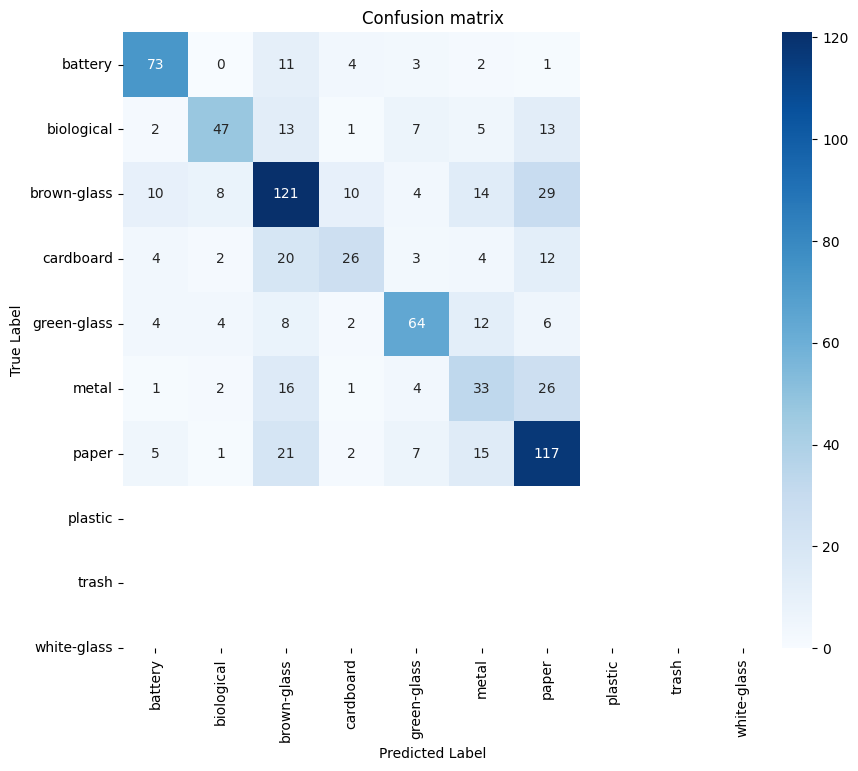

In [21]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion matrix')
plt.show()

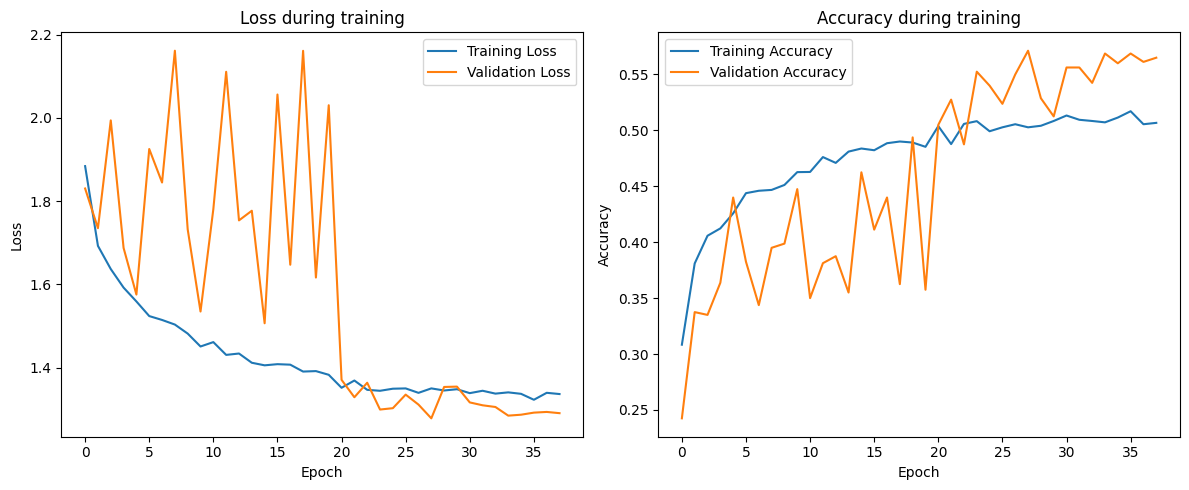

In [ ]:
# Loss and accuracy visualization during the training model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Found 822 validated image filenames belonging to 7 classes.
25/25 [==============================] - 28s 1s/step


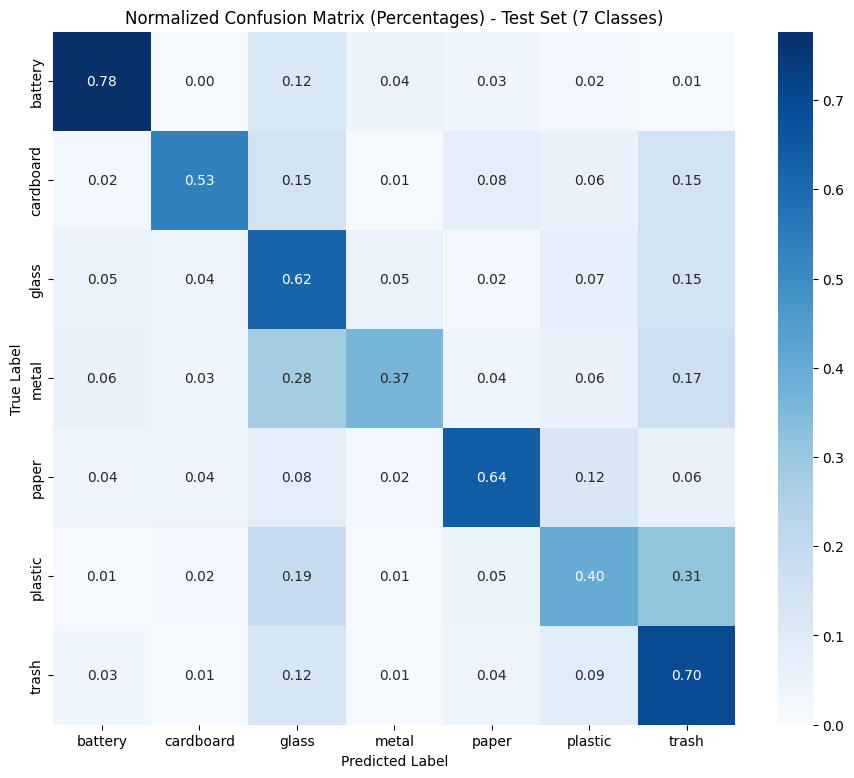

In [ ]:
# Re-load metadata and get the 7 new classes
all_classes = sorted(os.listdir(dataset_path))
classes_10 = [c for c in all_classes if c not in EXCLUDED_CLASSES]
metadata = []
for class_name in classes_10:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            metadata.append({"image_path": img_path, "class": class_name, "mapped_class": CLASS_MAPPING[class_name]})


# ImageDataGenerator for Test Set Evaluation
test_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator_eval = test_datagen_eval.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="mapped_class",  
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=new_classes,  
    seed=SEED,
    shuffle=False
)

# Load the Best Model (7 classes)
best_model = load_model('best_model_7_classes.h5')

# Obtain Predictions and True Tags for the Test Set
y_pred_test_probs = best_model.predict(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE)
y_pred_test = np.argmax(y_pred_test_probs, axis=1)
y_true_test = test_generator_eval.classes[:len(y_pred_test)]

# Calculate and Visualize the Normalized Confusion Matrix
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_normalized_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(11, 9))
sns.heatmap(cm_normalized_test, annot=True, fmt=".2f", cmap='Blues', xticklabels=new_classes, yticklabels=new_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Percentages) - Test Set (7 Classes)')
plt.show()

In [11]:
original_classes = ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass']
class_mapping3 = {
    'brown-glass': 'glass',
    'green-glass': 'glass',
    'white-glass': 'glass',
    'cardboard': 'paper',
    'paper': 'paper',
    'metal': 'plastic',
    'plastic': 'plastic',
    'battery': 'other',         
    'biological': 'other',      
    'trash': 'other'
}
mapped3_classes = sorted(list(set(class_mapping3.values())))
num_mapped3_classes = len(mapped3_classes)

# ImageDataGenerator for Test Set Evaluation
test_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator_eval = test_datagen_eval.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=original_classes, 
    seed=SEED,
    shuffle=False
)

best_model = load_model('best_model_10_classes.h5')

# Evaluation of the Model in the Test Set
loss_before, accuracy_before = best_model.evaluate(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss (before mapping): {loss_before:.4f}")
print(f"Test Accuracy (before mapping): {accuracy_before:.4f}")

# Obtain Predictions and True Tags for the Test Set
y_pred_probs = best_model.predict(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE)
y_pred_original = np.argmax(y_pred_probs, axis=1)
y_true_original = test_generator_eval.classes[:len(y_pred_original)]

# Mapping True and Predicted Tags to New Classes
y_mapped3_true = np.array([mapped3_classes.index(class_mapping3[original_classes[label]]) for label in y_true_original])
y_mapped3_pred = np.array([mapped3_classes.index(class_mapping3[original_classes[label]]) for label in y_pred_original])

# Evaluation of the Model in the Test Set (after mapping)
from sklearn.metrics import accuracy_score
accuracy_after = accuracy_score(y_mapped3_true, y_mapped3_pred)
print(f"Test Accuracy (after mapping): {accuracy_after:.4f}")

# Ranking Report (after mapping)
report_mapped3 = classification_report(y_mapped3_true, y_mapped3_pred, target_names=mapped3_classes, zero_division=0)
print("Classification Report (Test Set - after mapping):\n", report_mapped3)

Found 822 validated image filenames belonging to 10 classes.
25/25 [==============================] - 28s 1s/step - loss: 1.3027 - accuracy: 0.5913
Test Loss (before mapping): 1.3027
Test Accuracy (before mapping): 0.5913
25/25 [==============================] - 31s 1s/step
Test Accuracy (after mapping): 0.6675
Classification Report (Test Set - after mapping):
               precision    recall  f1-score   support

       glass       0.64      0.54      0.58       196
       other       0.76      0.78      0.77       262
       paper       0.69      0.74      0.72       188
     plastic       0.52      0.55      0.54       154

    accuracy                           0.67       800
   macro avg       0.65      0.65      0.65       800
weighted avg       0.67      0.67      0.67       800



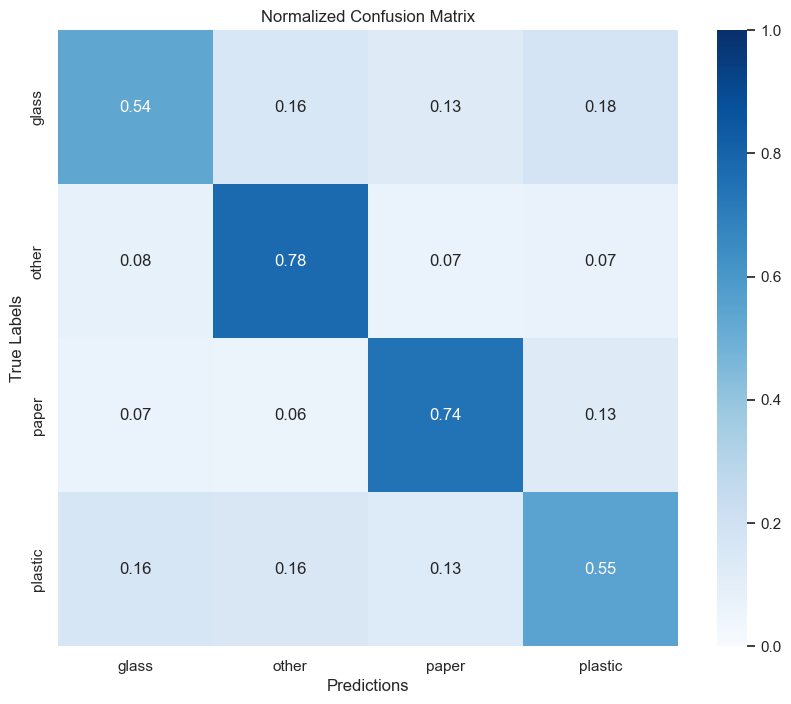

In [12]:
# Normalized Confusion Matrix
cm = confusion_matrix(y_mapped3_true, y_mapped3_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm_normalized, 
                      annot=True, 
                      fmt='.2f', 
                      cmap='Blues', 
                      xticklabels=mapped3_classes, 
                      yticklabels=mapped3_classes,
                      vmin=0, 
                      vmax=1)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

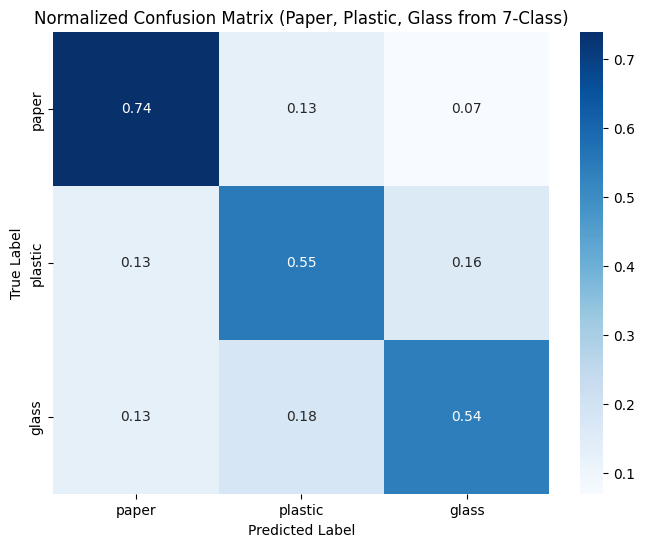

In [11]:
classes = ['paper', 'plastic', 'glass']

original_matrix = np.array([
    [0.54, 0.16, 0.13, 0.18], 
    [0.08, 0.78, 0.07, 0.07], 
    [0.07, 0.06, 0.74, 0.13], 
    [0.16, 0.16, 0.13, 0.55]  
])

personalized_matrix = np.array([
    original_matrix[2, [2, 3, 0]],  
    original_matrix[3, [2, 3, 0]], 
    original_matrix[0, [2, 3, 0]]   # 
])

plt.figure(figsize=(8, 6))
sns.heatmap(personalized_matrix,
            annot=True,
            fmt=".2f",
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Paper, Plastic, Glass from 7-Class)')
plt.show()

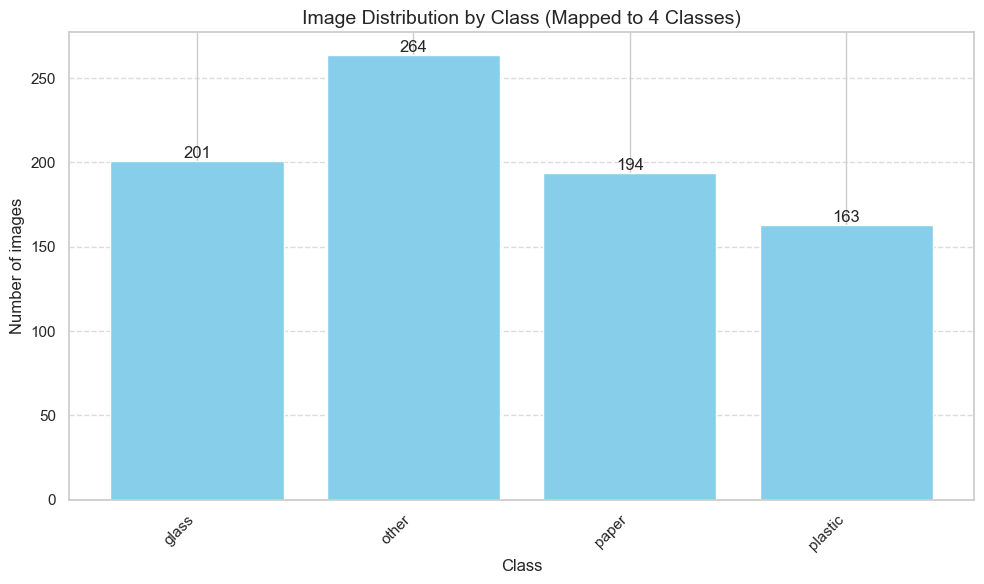

In [14]:
# Map the original classes to the new 4 classes in the DataFrame
test_df['mapped_class'] = test_df['class'].map(class_mapping3)

# Count the number of images per mapped class
class_counts = test_df['mapped_class'].value_counts().reindex(mapped3_classes, fill_value=0)

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')

plt.title('Image Distribution by Class (Mapped to 4 Classes)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout() 
plt.show()